# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV

%matplotlib inline

# Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias_df = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers_df = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

attr_df = pd.read_excel('../../data/Term2/capstone/arvato_data/DIAS Information Levels - Attributes 2017.xlsx')
values_df = pd.read_excel('../../data/Term2/capstone/arvato_data/DIAS Attributes - Values 2017.xlsx')

C:\Users\pietr\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


**Not all variables are described in the XLSX files. At least 50 variables from the main datasets (CSV files) are and what to expect from them.**

In [3]:
len(attr_df.Attribute.unique()), len(values_df.Attribute.unique()), azdias_df.shape[1], customers_df.shape[1]

(313, 315, 366, 369)

In [4]:
len(np.setdiff1d(azdias_df.columns, values_df['Attribute'].unique().tolist()))

94

**Several variable names are slightly different in the XLSX files compared to the CSV files. I corrected some of them to match, but 61 columns in the dataset continue to be undescribed.**

In [5]:
correct_names=[]
for name in values_df['Attribute']:
    if bool(re.search(r'RZ', str(name))):
        correct_names.append(name[:-3])
    else:
        correct_names.append(name)
values_df['Attribute'] = correct_names
values_df.fillna(method='ffill', inplace=True) # complete nans with previous value

In [6]:
len(np.setdiff1d(azdias_df.columns, values_df['Attribute'].unique().tolist()))

61

**Using the "unknown" definitions from the values dataframe as reference, I verified all values from the CSV files and transformed them into nans when necessary.**

In [7]:
unknown_list = [bool(re.search('unknown', str(x))) for x in values_df['Meaning'].tolist()]
unknown_df = values_df[unknown_list]

In [8]:
unknown_list = [bool(re.search('unknown', str(x))) for x in values_df['Meaning'].tolist()]
unknown_df = values_df[unknown_list]
def make_unknown_nan(input_df):
    '''
    Replace values that represent unknown information with nans. 
    
    INPUT
    - input_df: dataframe to be fixed.
    
    OUTPUT
    - output_df: dataframe with unknown values replaced with nans.
    
    '''
    
    output_df = input_df.copy()
    n_corrected = 0 # keep track of corrections
    cols_to_parse = unknown_df['Attribute'].values
    cols_to_parse = cols_to_parse[np.isin(cols_to_parse, output_df.columns.values)]
    
    for col in cols_to_parse:
        unknown_val = unknown_df[unknown_df['Attribute'] == col]['Value'].values[0]
        try:
            unknown_val = unknown_val.split(',')
        except:
            unknown_val = [unknown_val]
        for val in unknown_val:
            n_unknown = len(output_df.loc[output_df[col] == float(val), col])
            if n_unknown > 0:
                n_corrected += n_unknown
                output_df.loc[output_df[col] == float(val), col] = np.nan
    return output_df, n_corrected

In [9]:
azdias_clean_df, azdias_n_corrected = make_unknown_nan(azdias_df)
customers_clean_df, customers_n_corrected = make_unknown_nan(customers_df)

In [10]:
print('{} values from the azdias dataframe and {} values from the customers dataframe were transformed to nans'.format(azdias_n_corrected, customers_n_corrected))

3594594 values from the azdias dataframe and 623947 values from the customers dataframe were transformed to nans


### Dealing with null values

In [11]:
azdias_col_null = azdias_clean_df.isnull().sum(axis=0)/azdias_clean_df.shape[0]
azdias_row_null = azdias_clean_df.isnull().sum(axis=1)/azdias_clean_df.shape[1]
customers_col_null = customers_clean_df.isnull().sum(axis=0)/customers_clean_df.shape[0]
customers_row_null = customers_clean_df.isnull().sum(axis=1)/customers_clean_df.shape[1]

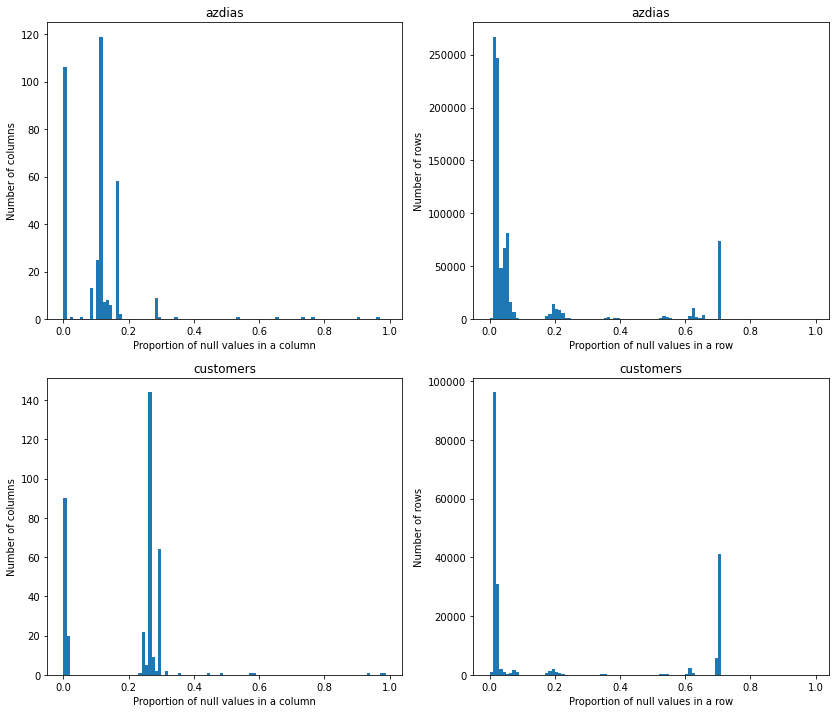

In [12]:
bins=np.arange(0, 1, 0.01)
plt.figure(figsize = [14, 12])
plt.subplot(2, 2, 1) # 2 rows, 2 cols, subplot 1
plt.hist(azdias_col_null, bins=bins)
plt.title('azdias')
plt.ylabel('Number of columns')
plt.xlabel('Proportion of null values in a column')
plt.subplot(2, 2, 2) #  2 rows, 2 cols, subplot 2
plt.hist(azdias_row_null, bins=bins)
plt.title('azdias')
plt.ylabel('Number of rows')
plt.xlabel('Proportion of null values in a row')
plt.subplot(2, 2, 3) #  2 rows, 2 cols, subplot 1
plt.hist(customers_col_null, bins=bins)
plt.title('customers')
plt.ylabel('Number of columns')
plt.xlabel('Proportion of null values in a column')
plt.subplot(2, 2, 4) #  2 rows, 2 cols, subplot 2
plt.hist(customers_row_null, bins=bins)
plt.title('customers')
plt.ylabel('Number of rows')
plt.xlabel('Proportion of null values in a row');

In [13]:
def custom_preprocess(input_df, row_null_threshold=0.15, col_null_threshold=0.75, extra_drops=False):
    '''
    Preprocess data of this project:
    - Removes non-numeric columns.
    - Drops rows and columns above certain null thresholds.
    - Impute values using the mode.
    - Normalizes data.
    
    INPUT
    - input_df: dataframe to be cleaned.
    - row_null_threshold: proportion threshold for rows to be dropped.
    - col_null_threshold: proportion threshold for columns to be dropped.
    - extra_drops: whether drop or not additional columns (for customers dataset).
    
    OUTPUT
    - output_df: dataframe cleaned.
    
    '''
    
    output_df = input_df.copy()
    output_df = make_unknown_nan(output_df)[0]
    output_df.set_index('LNR', inplace=True)
    
    if extra_drops:
        output_df.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)
    
    # remove non-numeric columns
    output_df = output_df.select_dtypes(exclude='object')
    
    # remove rows above null threshold
    row_null = output_df.isnull().sum(axis=1)/output_df.shape[1]
    
    rows_above_threshold = row_null[row_null>=row_null_threshold].index.values
    output_df.drop(index=rows_above_threshold,inplace=True)
    
    # remove columns above null threshold
    col_null = output_df.isnull().sum(axis=0)/output_df.shape[0]
    
    cols_above_threshold = col_null[col_null>=col_null_threshold].index.values
    output_df.drop(columns=cols_above_threshold,inplace=True)
    
    # impute null values using the mode
    transformer = SimpleImputer(missing_values=np.nan,strategy='most_frequent')
    output_df = pd.DataFrame(transformer.fit_transform(output_df), columns=output_df.columns.values, index=output_df.index.values)
    
    # scale values
    scaler = StandardScaler()
    output_df = pd.DataFrame(scaler.fit_transform(output_df), columns=output_df.columns.values, index=output_df.index.values)
    
    return output_df

In [14]:
azdias_clean_df = custom_preprocess(azdias_df)
customers_clean_df = custom_preprocess(customers_df, extra_drops=True)

**No null values:**

In [15]:
azdias_clean_df.isnull().sum().sum(), customers_clean_df.isnull().sum().sum()

(0, 0)

**Original dataframe dimensions:**

In [16]:
azdias_df.shape, customers_df.shape

((891221, 366), (191652, 369))

**New dataframe dimensions:**

In [17]:
azdias_clean_df.shape, customers_clean_df.shape

((737288, 354), (134246, 354))

# Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## PCA

**Before clustering data, I need first to reduce data dimensions to increase efficiency of clustering.** 

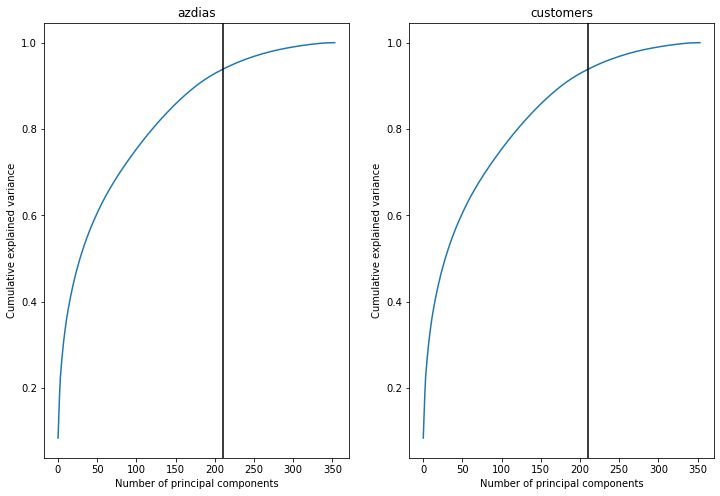

In [18]:
pca = PCA()
azdias_pca = pca.fit_transform(azdias_clean_df)

plt.figure(figsize = [12, 8])
plt.subplot(1, 2, 1) # 1 row, 2 cols, subplot 1
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axvline(x=210, color='black')
plt.title('azdias')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explained variance')


pca = PCA()
customers_pca = pca.fit_transform(azdias_clean_df)

plt.subplot(1, 2, 2) # 1 row, 2 cols, subplot 2
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axvline(x=210, color='black')
plt.title('customers')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explained variance')

plt.show()

**These plots suggest that around 210 components the explained variance gain decreases substantially with more components. Thus, I chose that number of principal components to reduce data dimensions.**

In [19]:
def reduce_dimensions(input_df, n=210):
    '''
    Applies PCA on data to reduce their dimensions.
    
    INPUT
    - input_df: data to be reduced.
    
    OUTPUT
    - output_df: reduced data.
    
    '''
    
    pca = PCA(n_components=n)
    output_df = pd.DataFrame(pca.fit_transform(input_df))
    print(pca.explained_variance_ratio_.sum())
    
    return output_df

In [20]:
azdias_pca = reduce_dimensions(azdias_clean_df)
customers_pca = reduce_dimensions(customers_clean_df)

0.9366292889249688
0.9310906210766171


## Clustering

**Now that the data is reduced, I apply the KMeans algorithm to cluster the data**.

In [21]:
def apply_cluster_algorithm(data, k):
    """
    Applies cluster algorithm on data using mean within-cluster distance.
    
    INPUT
    - input_df: reduced data to be clustered.
    - k: number of clusters.
    
    OUTPUT
    - within-cluster distances.
    """
    kmeans = KMeans(k)
    model = kmeans.fit(data)
    
    return abs(model.score(data))

**I chose 11 as the number of clusters to use. Although greater number of clusters would reduce further within-cluster distance, the rate in which that happens is much lower after 11 clusters.**

In [22]:
%%time
distances = []
centers = np.arange(1, 31)
for k in centers:
    distances.append(apply_cluster_algorithm(azdias_pca.sample(40000), k))

Wall time: 6min 15s


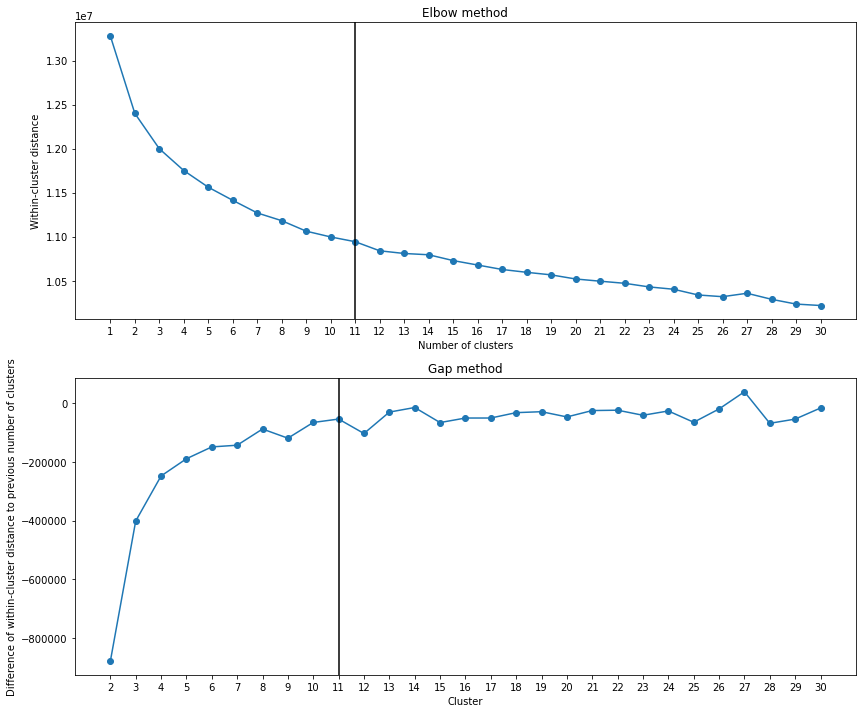

In [23]:
plt.figure(figsize = [14, 12])
plt.subplot(2, 1, 1) # 1 row, 2 cols, subplot 1
plt.plot(centers, distances, linestyle='-', marker='o')
plt.ylabel('Within-cluster distance')
plt.xlabel('Number of clusters')
plt.title('Elbow method')
plt.axvline(x=11, color='black')
plt.xticks(np.linspace(1,30,30));

plt.subplot(2, 1, 2) # 1 row, 2 cols, subplot 1
plt.plot(centers[1:], np.diff(distances), linestyle='-', marker='o')
plt.ylabel('Difference of within-cluster distance to previous number of clusters')
plt.xlabel('Cluster')
plt.title('Gap method')
plt.axvline(x=11, color='black')
plt.xticks(np.linspace(2,30,29));

**The difference between clusters of the general population (azdias) and customers is greater for clusters 1 (customer overrepresentation) and 4 (customer underrepresentation).**

In [24]:
%%time
kmeans = KMeans(n_clusters=11)

azdias_pred = kmeans.fit_predict(azdias_pca)
customers_pred = kmeans.fit_predict(customers_pca)

Wall time: 3min 34s


In [25]:
cluster_dist = pd.DataFrame({'cluster':np.unique(azdias_pred, return_counts=True)[0],
                             'azdias':np.unique(azdias_pred, return_counts=True)[1]/len(azdias_pred),
                             'customers':np.unique(customers_pred, return_counts=True)[1]/len(customers_pred)})
cluster_dist['diff'] = cluster_dist['customers'] - cluster_dist['azdias']

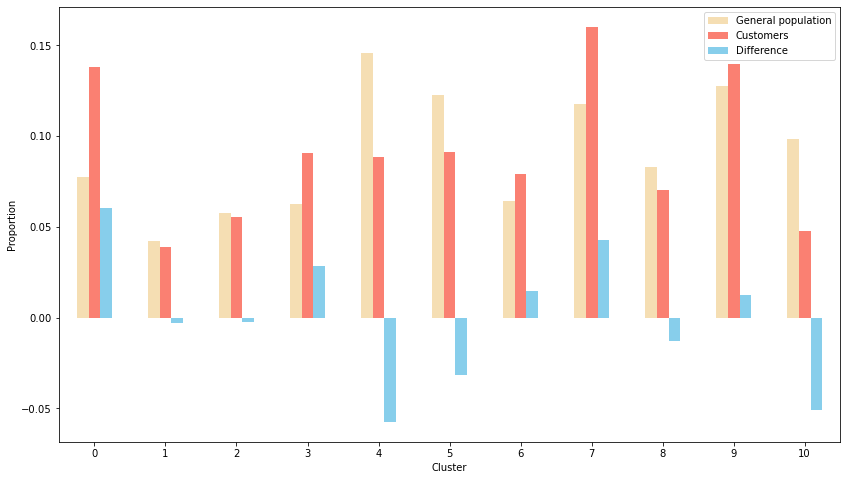

In [26]:
fig, ax = plt.subplots(figsize = [14, 8])
cluster_dist.plot.bar(x = 'cluster', y = ['azdias', 'customers', 'diff'], ax = ax, color=['wheat', 'salmon', 'skyblue'])
plt.legend(labels=['General population', 'Customers', 'Difference'])
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.xticks(rotation=0);

# Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [27]:
train_df = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

train_clean_df = custom_preprocess(train_df)

# because response was normalized during the preprocess, I converted to its original state
train_clean_df['RESPONSE'] = np.where(train_clean_df['RESPONSE']>0, 1, 0)

X = train_clean_df.drop(columns=['RESPONSE'])
y = train_clean_df['RESPONSE']

C:\Users\pietr\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


**There is a huge imbalance in the response variable: only a few people became customers following the campaign.**

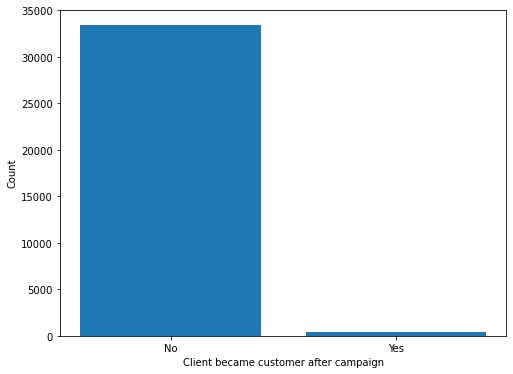

In [28]:
labels, counts = np.unique(y, return_counts=True)
labels = np.where(labels==0, 'No', 'Yes')

plt.figure(figsize = [8, 6])
plt.bar(x=labels, height=counts)
plt.xlabel('Client became customer after campaign')
plt.ylabel('Count');

## Model evaluation and validation

**Taking into consideration the imbalance in the response variable, I used GridSearchCV which applies stratified-K-fold to train and test the data. Also because of this imbalance, ROC/AUC is the most appropriate measure to evaluate the performance of the classifiers.**

In [29]:
def fit_clf(clf, param_grid, X=X, y=y):
    """
    Fit a classifier and computes its ROC/AUC.
    
    INPUT:
    - classifier: algorithm to be used 
    - param_grid: parameters of the classifier used
    - X: data frame with predictor variables
    - y: response variable
            
    OUTPUT:
    - combination of parameters with the greatest ROC/AUC score
    - ROC/AUC score of the best parameter combination (if different parameters used)
    
    """
    
    # using StratifiedKFold
    
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X, y)
    print(grid.best_score_)
    
    return grid.best_estimator_, grid.best_score_

**Logistic regression**

In [30]:
clf = LogisticRegression()
estimator, score = fit_clf(clf, {})

C:\Users\pietr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\pietr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

0.6749092590810871


C:\Users\pietr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Random forest classifier**

In [31]:
clf = RandomForestClassifier()
estimator, score = fit_clf(clf, {})

0.6166169361759973


**Gradient boosting classifier**

In [32]:
clf = GradientBoostingClassifier()
estimator, score = fit_clf(clf, {})

0.7663379686776048


## Tuning the selected algorithm

**Gradient boosting classifier had the best score on its default parameters than the other two algorithms used, so I use it from here one, tweaking some of its parameters.**

In [33]:
%%time
clf = GradientBoostingClassifier()

params = {'min_samples_leaf': [1, 2],
          'n_estimators': [100, 150]} 

estimator, score = fit_clf(clf, params)
best_estimator = estimator

0.7679723269957239
Wall time: 16min 5s


In [40]:
best_estimator

GradientBoostingClassifier(n_estimators=150)

# Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [34]:
test_df = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

C:\Users\pietr\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [35]:
def custom_preprocess_mod(input_df, col_null_threshold=0.75, extra_drops=False):
    '''
    Modified preprocess data for test data only. It does not drop rows.
    - Removes non-numeric columns.
    - Drops columns above certain null thresholds.
    - Impute values using the mode.
    - Normalizes data.
    
    INPUT
    - input_df: dataframe to be cleaned.
    - col_null_threshold: proportion threshold for columns to be dropped.
    - extra_drops: whether drop or not additional columns (for customers dataset).
    
    OUTPUT
    - output_df: dataframe cleaned.
    
    '''
    
    output_df = input_df.copy()
    output_df = make_unknown_nan(output_df)[0]
    output_df.set_index('LNR', inplace=True)
    
    if extra_drops:
        output_df.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)
    
    # remove non-numeric columns
    output_df = output_df.select_dtypes(exclude='object')
    
    # remove columns above null threshold
    col_null = output_df.isnull().sum(axis=0)/output_df.shape[0]
    
    cols_above_threshold = col_null[col_null>=col_null_threshold].index.values
    output_df.drop(columns=cols_above_threshold,inplace=True)
    
    # impute null values using the mode
    transformer = SimpleImputer(missing_values=np.nan,strategy='most_frequent')
    output_df = pd.DataFrame(transformer.fit_transform(output_df), columns=output_df.columns.values, index=output_df.index.values)
    
    # scale values
    scaler = StandardScaler()
    output_df = pd.DataFrame(scaler.fit_transform(output_df), columns=output_df.columns.values, index=output_df.index.values)
    
    return output_df

In [36]:
test_clean_df = custom_preprocess_mod(test_df)

## Predicting test data

In [37]:
preds = best_estimator.predict_proba(test_clean_df)[:, 1]

In [38]:
kaggle = pd.DataFrame({'LNR':test_clean_df.index.values, 'RESPONSE':preds}) 

In [39]:
kaggle

,LNR,RESPONSE
0,1754,0.049912
1,1770,0.017130
2,1465,0.031508
3,1470,0.002488
4,1478,0.034014
...,...,...
42828,67615,0.008226
42829,67938,0.010316
42830,67942,0.013050
42831,67949,0.019225
